In [73]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import joblib
import json
import matplotlib.pyplot as plt

In [74]:
df = pd.read_csv("bank_transactions_data_2.csv")

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2512 non-null   object 
 1   AccountID                2512 non-null   object 
 2   TransactionAmount        2512 non-null   float64
 3   TransactionDate          2512 non-null   object 
 4   TransactionType          2512 non-null   object 
 5   Location                 2512 non-null   object 
 6   DeviceID                 2512 non-null   object 
 7   IP Address               2512 non-null   object 
 8   MerchantID               2512 non-null   object 
 9   Channel                  2512 non-null   object 
 10  CustomerAge              2512 non-null   int64  
 11  CustomerOccupation       2512 non-null   object 
 12  TransactionDuration      2512 non-null   int64  
 13  LoginAttempts            2512 non-null   int64  
 14  AccountBalance          

In [76]:
cols_kept = ["TransactionDate", "TransactionType",  "Location", "Channel", "TransactionDuration", "LoginAttempts", "TransactionAmount"]
df = df[cols_kept]

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   TransactionDate      2512 non-null   object 
 1   TransactionType      2512 non-null   object 
 2   Location             2512 non-null   object 
 3   Channel              2512 non-null   object 
 4   TransactionDuration  2512 non-null   int64  
 5   LoginAttempts        2512 non-null   int64  
 6   TransactionAmount    2512 non-null   float64
dtypes: float64(1), int64(2), object(4)
memory usage: 137.5+ KB


In [78]:
for col in df:
    print(f"{col}: {df[col].nunique()} unique values")

TransactionDate: 2405 unique values
TransactionType: 2 unique values
Location: 43 unique values
Channel: 3 unique values
TransactionDuration: 288 unique values
LoginAttempts: 5 unique values
TransactionAmount: 2455 unique values


In [79]:
# Split TransactionDate into Date and Time
df[['Date', 'Time']] = df['TransactionDate'].str.split(' ', expand=True)

# Drop the original TransactionDate column
df.drop('TransactionDate', axis=1, inplace=True)

# Convert Date to datetime format (DD/MM/YYYY)
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', dayfirst=True)

# Convert Time from HH:MM to total seconds since midnight
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M').dt.hour * 3600 + pd.to_datetime(df['Time'], format='%H:%M').dt.minute * 60

# Extract the day of the week from the Date column
df['DayOfWeek'] = df['Date'].dt.day_name()  # Monday, Tuesday, etc.

In [80]:
# 🟢 Step 2: Encode Categorical Variables
encoder = LabelEncoder()
categorical_cols = ["Location"]
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])


In [81]:
location_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
location_mapping_json = {key: int(value) for key, value in location_mapping.items()}

In [82]:
# Save as JSON
with open("location_mapping.json", "w") as f:
    json.dump(location_mapping_json, f, indent=4)

print("Mapping saved to location_mapping.json")

Mapping saved to location_mapping.json


In [83]:
# Manually map categorical values
transaction_type_mapping = {"Debit": 0, "Credit": 1}
channel_mapping = {"ATM": 0, "Online": 1, "Branch": 2}
day_of_week_mapping = {
    "Monday": 0, "Tuesday": 1, "Wednesday": 2, 
    "Thursday": 3, "Friday": 4, "Saturday": 5, "Sunday": 6
}

# Apply mappings to the respective columns
df["TransactionType"] = df["TransactionType"].map(transaction_type_mapping)
df["Channel"] = df["Channel"].map(channel_mapping)
df["DayOfWeek"] = df["DayOfWeek"].map(day_of_week_mapping)


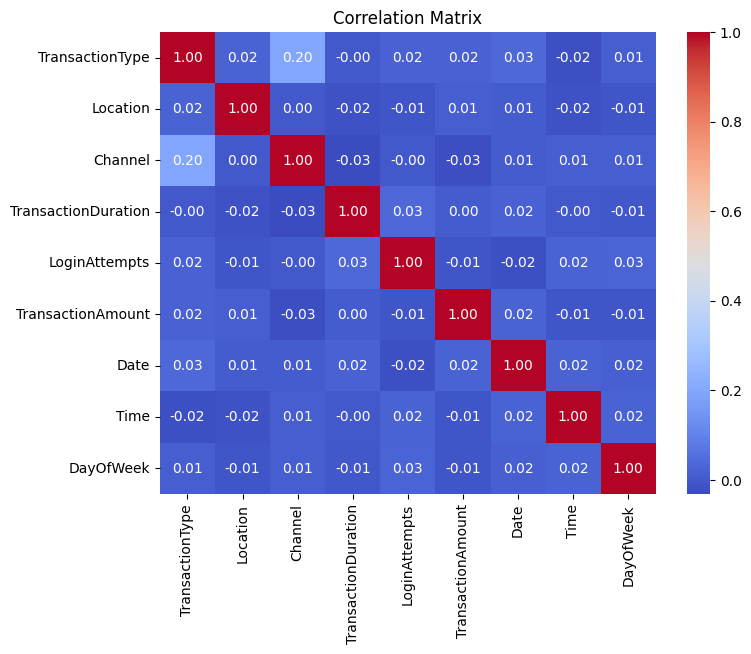

In [84]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.savefig("correlation_matrix.png")
plt.show()

In [85]:
# 🟢 Step 3: Select Features for Anomaly Detection
features = ["TransactionType", "Location", "Channel", "Time", "TransactionDuration", "LoginAttempts", "DayOfWeek", "TransactionAmount", ]
X = df[features]


In [86]:
model = IsolationForest(n_estimators=100, contamination=0.02, random_state=42)
df["Anomaly"] = model.fit_predict(X)


In [87]:
df["Anomaly"] = df["Anomaly"].map({1: "Normal", -1: "Anomalous"})

In [88]:
df.to_csv("cleaned_transactions.csv", index=False)

In [89]:
# Save the trained Isolation Forest model
joblib.dump(model, "isolation_forest_model.pkl")

print("Model saved as isolation_forest_model.pkl")

Model saved as isolation_forest_model.pkl


In [90]:
df[["DayOfWeek", "Time","Location", "Channel", "TransactionDuration", "TransactionAmount", "Anomaly"]].head(10)

DayOfWeek   Time  Location  Channel  TransactionDuration  \
0          1  59340        36        0                   81   
1          1  60240        15        0                  141   
2          0  65760        23        1                   56   
3          4  59520        33        1                   25   
4          0  64260         1        1                  198   
5          0  62100        28        0                  172   
6          2  59760        39        0                  139   
7          0  64020        16        2                  291   
8          1  61140        11        2                   86   
9          4  57960        26        0                  120   

   TransactionAmount Anomaly  
0              14.09  Normal  
1             376.24  Normal  
2             126.29  Normal  
3             184.50  Normal  
4              13.45  Normal  
5              92.15  Normal  
6               7.08  Normal  
7             171.42  Normal  
8             106.23  Normal  
9             815.96  Normal

<Axes: xlabel='Time', ylabel='TransactionAmount'>

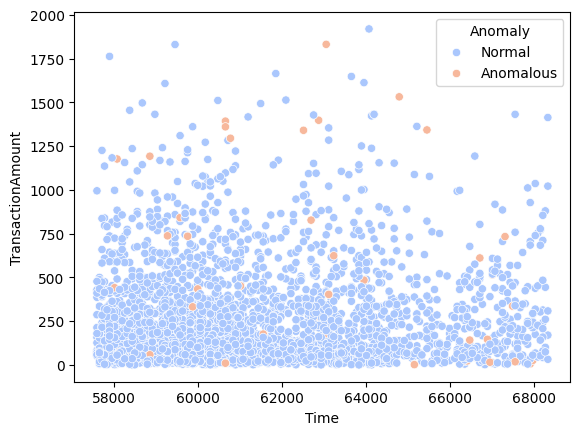

In [91]:
sns.scatterplot(x=df["Time"], y=df["TransactionAmount"], hue=df["Anomaly"], palette="coolwarm")

<Axes: xlabel='TransactionDuration', ylabel='Channel'>

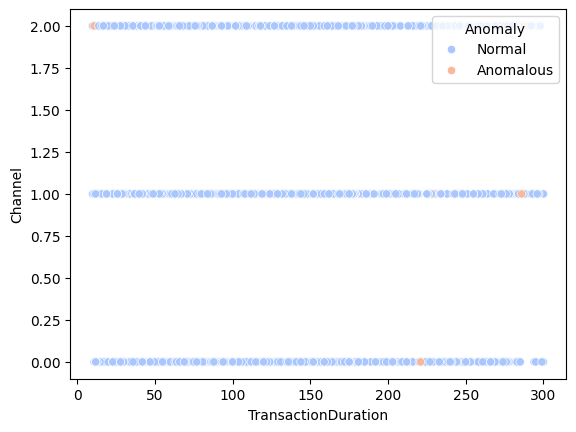

In [92]:
sns.scatterplot(x=df["TransactionDuration"], y=df["Channel"], hue=df["Anomaly"], palette="coolwarm")

<Axes: xlabel='LoginAttempts', ylabel='TransactionAmount'>

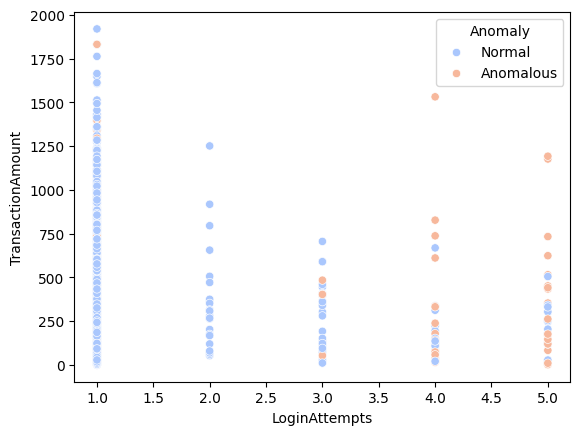

In [93]:
sns.scatterplot(x=df["LoginAttempts"], y=df["TransactionAmount"], hue=df["Anomaly"], palette="coolwarm")